In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
from scipy.special import gamma
from scipy.integrate import quad

In [2]:
%matplotlib inline
pp.style.use('seaborn-ticks')

In [3]:
tfile = uproot.open('/home/kbartlett/Documents/Qweak/al_measured_asymmetry/dbrootfiles/aluminum_run2/DS-4%-Aluminum_offoff_tree.root')

In [4]:
ttree = tfile.get('tree')

In [5]:
run_data = ttree.array('run_number')
slug_data = ttree.array('slug')
wien_data = ttree.array('wien_slug')
sc_data = ttree.array('sign_correction')
quality_id_data = ttree.array('runlet_quality_id')
mdall_data = ttree.array('asym_mdallpmtavg')
bcm5_data = ttree.array('asym_qwk_bcm5')
bcm6_data = ttree.array('asym_qwk_bcm6')
bcm7_data = ttree.array('asym_qwk_bcm7')
bcm8_data = ttree.array('asym_qwk_bcm8')
bcmdd56_data = ttree.array('asym_bcmdd56')
bcmdd57_data = ttree.array('asym_bcmdd57')
bcmdd58_data = ttree.array('asym_bcmdd58')
bcmdd67_data = ttree.array('asym_bcmdd67')
bcmdd68_data = ttree.array('asym_bcmdd68')
bcmdd78_data = ttree.array('asym_bcmdd78')

In [6]:
#ttree.fBranches

In [7]:
df = pd.DataFrame({'run':run_data, 'slug':slug_data, 'wien':wien_data, 'sc':sc_data, 'quality_id':quality_id_data})

In [8]:
mdall_df = pd.DataFrame(mdall_data)

In [9]:
bcm5_df = pd.DataFrame(bcm5_data)
bcm6_df = pd.DataFrame(bcm6_data)
bcm7_df = pd.DataFrame(bcm7_data)
bcm8_df = pd.DataFrame(bcm8_data)

In [10]:
bcmdd56_df = pd.DataFrame(bcmdd56_data)
bcmdd57_df = pd.DataFrame(bcmdd57_data)
bcmdd58_df = pd.DataFrame(bcmdd58_data)
bcmdd67_df = pd.DataFrame(bcmdd67_data)
bcmdd68_df = pd.DataFrame(bcmdd68_data)
bcmdd78_df = pd.DataFrame(bcmdd78_data)

In [11]:
def add_prefix(df, tag):
    df.columns = [tag + '_' + i for i in df.columns]

In [12]:
add_prefix(mdall_df, 'mdall')

In [13]:
add_prefix(bcm5_df, 'bcm5')
add_prefix(bcm6_df, 'bcm6')
add_prefix(bcm7_df, 'bcm7')
add_prefix(bcm8_df, 'bcm8')

In [14]:
add_prefix(bcmdd56_df, 'bcmdd56')
add_prefix(bcmdd57_df, 'bcmdd57')
add_prefix(bcmdd58_df, 'bcmdd58')
add_prefix(bcmdd67_df, 'bcmdd67')
add_prefix(bcmdd68_df, 'bcmdd68')
add_prefix(bcmdd78_df, 'bcmdd78')

In [15]:
df = pd.concat([df, mdall_df, bcm5_df, bcm6_df, bcm7_df, bcm8_df, bcmdd56_df, bcmdd57_df, bcmdd58_df, bcmdd67_df, bcmdd68_df, bcmdd78_df], axis=1)

In [16]:
df.head()

,quality_id,run,sc,slug,wien,mdall_value,mdall_err,mdall_rms,mdall_n,bcm5_value,...,bcmdd67_rms,bcmdd67_n,bcmdd68_value,bcmdd68_err,bcmdd68_rms,bcmdd68_n,bcmdd78_value,bcmdd78_err,bcmdd78_rms,bcmdd78_n
0,2,14153,-1,1028,6,-105.283740,42.749554,579.883167,184,-4.735933,...,74.748955,184,-4.583193,4.838478,65.632311,184,-7.702616,5.148243,69.834171,184
1,1,14153,-1,1028,6,3.795485,2.524236,629.562917,62204,-0.866824,...,79.643723,62194,0.270440,0.283883,70.802371,62204,0.331842,0.248201,61.898077,62194
2,1,14153,-1,1028,6,-3.396661,2.522684,628.259718,62023,-0.540828,...,79.749494,62017,0.792501,0.284275,70.797065,62023,0.390035,0.248560,61.899407,62017
3,1,14153,-1,1028,6,-3.498164,2.543538,634.621740,62252,-0.351597,...,82.829357,62236,-0.188329,0.298347,74.438631,62252,-0.115097,0.247723,61.799912,62236
4,1,14153,-1,1028,6,-4.673153,2.507497,625.141658,62155,0.042250,...,81.622623,62149,0.219309,0.292150,72.835642,62155,0.012722,0.246534,61.460175,62149


In [17]:
def slug_avg(df, bcm, slug):
    avg, sow = np.average(df.query('quality_id == 1 & slug == {0}'.format(slug))['bcm{0}_value'.format(bcm)]*df.query('quality_id == 1 & slug == {0}'.format(slug))['sc'],
                      weights=1/np.square(df.query('quality_id == 1 & slug == {0}'.format(slug))['bcm{0}_err'.format(bcm)]),
                      returned = True)
    err = 1/np.sqrt(sow)
    return avg, err

def dd_slug_avg(df, bcm, slug):
    avg, sow = np.average(df.query('quality_id == 1 & slug == {0}'.format(slug))['bcmdd{0}_value'.format(bcm)],
                      weights=1/np.square(df.query('quality_id == 1 & slug == {0}'.format(slug))['bcmdd{0}_err'.format(bcm)]),
                      returned = True)
    err = 1/np.sqrt(sow)
    return avg, err

In [18]:
def wien_avg(df, bcm, wien):
    avg, sow = np.average(df.query('quality_id == 1 & wien == {0}'.format(wien))['bcm{0}_value'.format(bcm)]*df.query('quality_id == 1 & wien == {0}'.format(wien))['sc'],
                      weights=1/np.square(df.query('quality_id == 1 & wien == {0}'.format(wien))['bcm{0}_err'.format(bcm)]),
                      returned = True)
    err = 1/np.sqrt(sow)
    return avg, err 

def dd_wien_avg(df, bcm, wien):
    avg, sow = np.average(df.query('quality_id == 1 & wien == {0}'.format(wien))['bcmdd{0}_value'.format(bcm)],
                      weights=1/np.square(df.query('quality_id == 1 & wien == {0}'.format(wien))['bcmdd{0}_err'.format(bcm)]),
                      returned = True)
    err = 1/np.sqrt(sow)
    return avg, err 

In [19]:
slug_num = np.unique(df.query('slug >= 1028 & slug <=1058 & quality_id == 1')['slug'])
wien_num = [6,8,9]

In [20]:
def calc_slug_avg(df, bcm):
    avg = np.array([slug_avg(df, bcm, slug)[0] for slug in slug_num])
    err = np.array([slug_avg(df, bcm, slug)[1] for slug in slug_num])
    return avg, err

def calc_dd_slug_avg(df, bcm):
    avg = np.array([dd_slug_avg(df, bcm, slug)[0] for slug in slug_num])
    err = np.array([dd_slug_avg(df, bcm, slug)[1] for slug in slug_num])
    return avg, err

In [21]:
def calc_wien_avg(df, bcm):
    avg = np.array([wien_avg(df, bcm, wien)[0] for wien in wien_num])
    err = np.array([wien_avg(df, bcm, wien)[1] for wien in wien_num])
    return avg, err

def calc_dd_wien_avg(df, bcm):
    avg = np.array([dd_wien_avg(df, bcm, wien)[0] for wien in wien_num])
    err = np.array([dd_wien_avg(df, bcm, wien)[1] for wien in wien_num])
    return avg, err

In [22]:
slug_bcm5_avg, slug_bcm5_err = calc_slug_avg(df, 5)
slug_bcm6_avg, slug_bcm6_err = calc_slug_avg(df, 6)
slug_bcm7_avg, slug_bcm7_err = calc_slug_avg(df, 7)
slug_bcm8_avg, slug_bcm8_err = calc_slug_avg(df, 8)

In [23]:
wien_bcm5_avg, wien_bcm5_err = calc_wien_avg(df, 5)
wien_bcm6_avg, wien_bcm6_err = calc_wien_avg(df, 6)
wien_bcm7_avg, wien_bcm7_err = calc_wien_avg(df, 7)
wien_bcm8_avg, wien_bcm8_err = calc_wien_avg(df, 8)

wien_bcmdd56_avg, wien_bcmdd56_err = calc_dd_wien_avg(df, 56)
wien_bcmdd57_avg, wien_bcmdd57_err = calc_dd_wien_avg(df, 57)
wien_bcmdd58_avg, wien_bcmdd58_err = calc_dd_wien_avg(df, 58)
wien_bcmdd67_avg, wien_bcmdd67_err = calc_dd_wien_avg(df, 67)
wien_bcmdd68_avg, wien_bcmdd68_err = calc_dd_wien_avg(df, 68)
wien_bcmdd78_avg, wien_bcmdd78_err = calc_dd_wien_avg(df, 78)

In [24]:
def const_fit(data, data_err):
    "Function to calculate the error-weighted average, return fit chi2 stats"
    
    # Error weighted average
    avg, sow = np.average(data,
                          weights=1/np.square(data_err),
                          returned=True)
    avg_err = 1/np.sqrt(sow)
    dof = len(data) - 1
    chi2 = calc_chi2(data, data_err, avg)
    prob = calc_chi2prob(chi2, dof)
    return avg, avg_err, chi2/dof, prob[0]


def calc_chi2(data, data_err, fit):
    chi2 = np.sum(np.square(data-fit)/np.square(data_err))
    return chi2


def chi2probdistribution(chi2, dof):
    if chi2 > 0:
        num = np.power(chi2, (dof-2.0)/2.0)*np.exp(-chi2/2.0)
        dem = np.power(2.0, (dof/2.0))*gamma(dof/2.0)
        return num/dem
    elif chi2 == 0:
        return 0
    else:
        print('Chi^2 value < 0 not valid!')


def calc_chi2prob(chi2, dof):
    return quad(chi2probdistribution, chi2, np.inf, dof)


def print_fit_info(label, avg, avg_err, rchi2, prob):
    print(label)
    print('  Avg: {0:.6} [ppm]'.format(avg))
    print('  Err: {0:.6} [ppm]'.format(avg_err))
    print('RChi2: {0:.4}'.format(rchi2))
    print(' Prob: {0:.4}\n'.format(prob))

In [25]:
print_fit_info('BCM6',*const_fit(slug_bcm6_avg, slug_bcm6_err))

BCM6
  Avg: -0.028715 [ppm]
  Err: 0.0401954 [ppm]
RChi2: 0.2764
 Prob: 0.9999



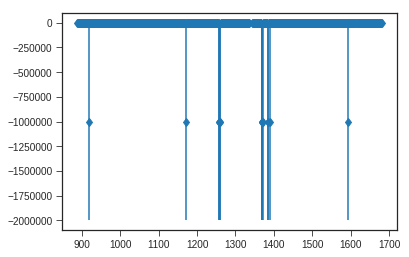

In [26]:
pp.figure()
pp.errorbar(df.query('wien == 9 & slug >= 1028 & slug <=1058 & quality_id == 1').index,
            df.query('wien == 9 & slug >= 1028 & slug <=1058 & quality_id == 1').bcm8_value,
            yerr=df.query('wien == 9 & slug >= 1028 & slug <=1058 & quality_id == 1').bcm8_err,
            ls='None',
            marker='d')
pp.show()

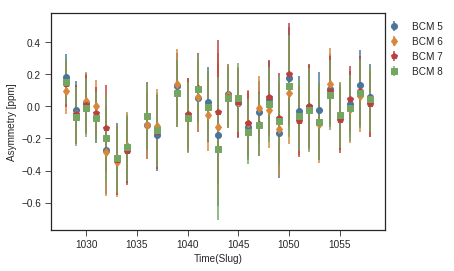

In [27]:
pp.figure()
pp.errorbar(slug_num, slug_bcm5_avg, yerr=slug_bcm5_err, ls='None', marker='o', color=sns.xkcd_rgb['dull blue'], label='BCM 5')
pp.errorbar(slug_num, slug_bcm6_avg, yerr=slug_bcm6_err, ls='None', marker='d', color=sns.xkcd_rgb['dull orange'], label='BCM 6')
pp.errorbar(slug_num, slug_bcm7_avg, yerr=slug_bcm7_err, ls='None', marker='p', color=sns.xkcd_rgb['dull red'], label='BCM 7')
pp.errorbar(slug_num, slug_bcm8_avg, yerr=slug_bcm8_err, ls='None', marker='s', color=sns.xkcd_rgb['dull green'], label='BCM 8')
pp.xlabel('Time(Slug)')
pp.ylabel('Asymmetry [ppm]')
pp.legend(bbox_to_anchor=(1.2,1))
pp.tick_params(top=False)
pp.show()

In [28]:
print_fit_info('BCM8', *const_fit(wien_bcm8_avg, wien_bcm8_err))

BCM8
  Avg: -0.0301666 [ppm]
  Err: 0.0393266 [ppm]
RChi2: 0.4066
 Prob: 0.6659



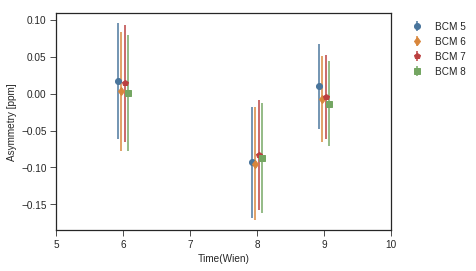

In [29]:
pp.figure()
pp.errorbar(wien_num-np.array(0.075), wien_bcm5_avg, yerr=wien_bcm5_err, ls='None', marker='o', color=sns.xkcd_rgb['dull blue'], label='BCM 5')
pp.errorbar(wien_num-np.array(0.025), wien_bcm6_avg, yerr=wien_bcm6_err, ls='None', marker='d', color=sns.xkcd_rgb['dull orange'], label='BCM 6')
pp.errorbar(wien_num+np.array(0.025), wien_bcm7_avg, yerr=wien_bcm7_err, ls='None', marker='p', color=sns.xkcd_rgb['dull red'], label='BCM 7')
pp.errorbar(wien_num+np.array(0.075), wien_bcm8_avg, yerr=wien_bcm8_err, ls='None', marker='s', color=sns.xkcd_rgb['dull green'], label='BCM 8')
pp.xlim(5,10)
pp.xlabel('Time(Wien)')
pp.ylabel('Asymmetry [ppm]')
pp.legend(bbox_to_anchor=(1.25,1))
pp.tick_params(top=False)
pp.show()

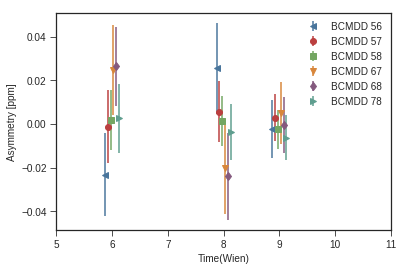

In [30]:
pp.figure()
pp.errorbar(wien_num-np.array(0.125), wien_bcmdd56_avg, yerr=wien_bcmdd56_err, ls='None', marker='<', color=sns.xkcd_rgb['dull blue'], label='BCMDD 56')
pp.errorbar(wien_num-np.array(0.075), wien_bcmdd57_avg, yerr=wien_bcmdd57_err, ls='None', marker='o', color=sns.xkcd_rgb['dull red'], label='BCMDD 57')
pp.errorbar(wien_num-np.array(0.025), wien_bcmdd58_avg, yerr=wien_bcmdd58_err, ls='None', marker='s', color=sns.xkcd_rgb['dull green'], label='BCMDD 58')
pp.errorbar(wien_num+np.array(0.025), wien_bcmdd67_avg, yerr=wien_bcmdd67_err, ls='None', marker='v', color=sns.xkcd_rgb['dull orange'], label='BCMDD 67')
pp.errorbar(wien_num+np.array(0.075), wien_bcmdd68_avg, yerr=wien_bcmdd68_err, ls='None', marker='d', color=sns.xkcd_rgb['dull purple'], label='BCMDD 68')
pp.errorbar(wien_num+np.array(0.125), wien_bcmdd78_avg, yerr=wien_bcmdd78_err, ls='None', marker='>', color=sns.xkcd_rgb['dull teal'], label='BCMDD 78')
pp.xlim(5,11)
pp.xlabel('Time(Wien)')
pp.ylabel('Asymmetry [ppm]')
#pp.legend(bbox_to_anchor=(1.3,1))
pp.legend(loc='upper right')
pp.tick_params(top=False)
pp.show()

In [31]:
print_fit_info('BCMDD56', *const_fit(wien_bcmdd56_avg, wien_bcmdd56_err))
print_fit_info('BCMDD57', *const_fit(wien_bcmdd57_avg, wien_bcmdd57_err))
print_fit_info('BCMDD58', *const_fit(wien_bcmdd58_avg, wien_bcmdd58_err))
print_fit_info('BCMDD67', *const_fit(wien_bcmdd67_avg, wien_bcmdd67_err))
print_fit_info('BCMDD68', *const_fit(wien_bcmdd68_avg, wien_bcmdd68_err))
print_fit_info('BCMDD78', *const_fit(wien_bcmdd78_avg, wien_bcmdd78_err))

BCMDD56
  Avg: -0.00170788 [ppm]
  Err: 0.0096235 [ppm]
RChi2: 1.481
 Prob: 0.2275

BCMDD57
  Avg: 0.00284228 [ppm]
  Err: 0.00757875 [ppm]
RChi2: 0.05137
 Prob: 0.9499

BCMDD58
  Avg: -0.0003844 [ppm]
  Err: 0.00628346 [ppm]
RChi2: 0.05018
 Prob: 0.9511

BCMDD67
  Avg: 0.00395586 [ppm]
  Err: 0.0102331 [ppm]
RChi2: 1.177
 Prob: 0.3081

BCMDD68
  Avg: 0.00148094 [ppm]
  Err: 0.0092799 [ppm]
RChi2: 1.746
 Prob: 0.1744

BCMDD78
  Avg: -0.00368537 [ppm]
  Err: 0.00711879 [ppm]
RChi2: 0.1124
 Prob: 0.8937



In [37]:
[const_fit(wien_bcmdd78_avg, wien_bcmdd78_err)[0] - const_fit(wien_bcmdd68_avg, wien_bcmdd68_err)[0],
const_fit(wien_bcmdd78_avg, wien_bcmdd78_err)[0] - const_fit(wien_bcmdd67_avg, wien_bcmdd67_err)[0],
const_fit(wien_bcmdd78_avg, wien_bcmdd78_err)[0] - const_fit(wien_bcmdd58_avg, wien_bcmdd58_err)[0],
const_fit(wien_bcmdd78_avg, wien_bcmdd78_err)[0] - const_fit(wien_bcmdd57_avg, wien_bcmdd57_err)[0],
const_fit(wien_bcmdd78_avg, wien_bcmdd78_err)[0] - const_fit(wien_bcmdd56_avg, wien_bcmdd56_err)[0]]

[-0.005166314381262094,
 -0.007641235928532559,
 -0.0033009712597843405,
 -0.00652765561973076,
 -0.00197748926608047]

In [30]:
bcm5_mean = const_fit(wien_bcm5_avg, wien_bcm5_err)[:2]
bcm6_mean = const_fit(wien_bcm6_avg, wien_bcm6_err)[:2]
bcm8_mean = const_fit(wien_bcm8_avg, wien_bcm8_err)[:2]

In [31]:
md_asym = (1.4410, 0.0678)

In [32]:
def bcm_avg(bcm5, bcm6, bcm8):
    return np.average([bcm5[0], bcm6[0], bcm8[0]])

In [33]:
bcm_avg(bcm5_mean, bcm6_mean, bcm8_mean)

-0.025163348110822714

In [34]:
bcm8_mean[0]

-0.030166565202891286

In [35]:
md_asym_renorm = md_asym[0]+bcm8_mean[0]-bcm_avg(bcm5_mean, bcm6_mean, bcm8_mean)

In [36]:
100*(md_asym[0]-md_asym_renorm)/md_asym[0]

0.34720451714563738